In [ ]:
# Importing everything needed for EDA, training, visualizing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time
import warnings
warnings.filterwarnings('ignore')

# For mapping
from mpl_toolkits.basemap import Basemap


Showing first 5 rows after cleaning:
   magnitude           date_time  cdi  mmi   alert  tsunami  sig  nst  \
0        6.5 2023-08-16 12:47:00    7    4   green        0  657  114   
1        6.5 2023-07-19 00:22:00    8    6  yellow        0  775   92   
2        6.6 2023-07-17 03:05:00    7    5   green        0  899   70   
3        7.2 2023-07-16 06:48:00    6    6   green        1  860  173   
4        7.3 2023-07-16 06:48:00    0    5     NaN        1  820   79   

       dmin    gap magType    depth  latitude  longitude      continent  \
0  7.177000   25.0     mww  192.955  -13.8814   167.1580        Unknown   
1  0.679000   40.0     mww   69.727   12.8140   -88.1265        Unknown   
2  1.634000   28.0     mww  171.371  -38.1911   -70.3731  South America   
3  0.907000   36.0     mww   32.571   54.3844  -160.6990        Unknown   
4  0.879451  172.8      Mi   21.000   54.4900  -160.7960        Unknown   

     country  
0    Vanuatu  
1    Unknown  
2  Argentina  
3    Unknown 

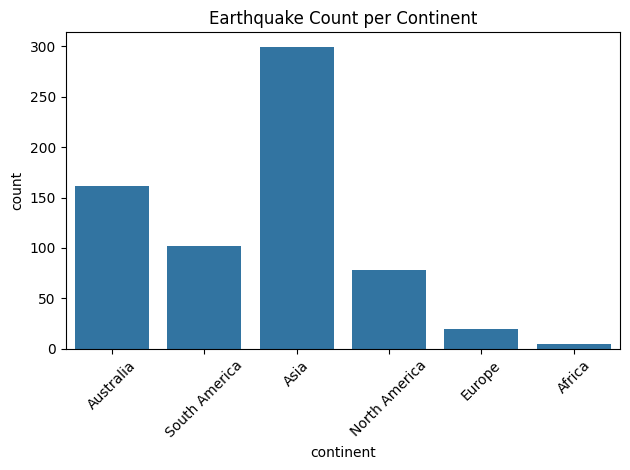

In [ ]:
# Loading dataset
df = pd.read_csv('/content/drive/MyDrive/earthquake_1995-2023.csv')

# Dropping non-useful text columns
df.drop(columns=['title', 'location', 'net'], inplace=True)

# Converting date_time and handling nulls
df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')
df['continent'].fillna('Unknown', inplace=True)
df['country'].fillna('Unknown', inplace=True)
# Printing first 5 rows after cleaning
print("Showing first 5 rows after cleaning:")
print(df.head())  # prints all columns for first 5 rows

# Fixing continent mapping here
import pycountry_convert as pc

def get_continent(country_name):
    try:
        country_code = pc.country_name_to_country_alpha2(country_name)
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return 'Unknown'

# Appling to 'Unknown' continents only
df['continent'] = df.apply(
    lambda row: get_continent(row['country']) if row['continent'] == 'Unknown' else row['continent'], axis=1)
# Fixing mismatched or invalid country names by replacing them with standard ones
country_fixes = {
    'United Kingdom of Great Britain and Northern Ireland (the)': 'United Kingdom',
    'Antarctica': 'Unknown'  # marking Antarctica as Unknown since it's not a typical continent for human quakes
}


# Replacing the incorrect country names using the dictionary above
df['country'] = df['country'].replace(country_fixes)

# Reapplying continent mapping only for rows still showing Unknown after fixing country names
df['continent'] = df.apply(
    lambda row: get_continent(row['country']) if row['continent'] == 'Unknown' else row['continent'], axis=1
)
df['continent'] = df['continent'].replace('Oceania', 'Australia')

# Dropping or ignoring remaining rows that still have continent marked as Unknown
# (this is helping in getting cleaner visualizations)
df = df[df['continent'] != 'Unknown']

# Plotting again after cleaning and re-mapping continents properly
sns.countplot(x='continent', data=df)
plt.title("Earthquake Count per Continent")
plt.xticks(rotation=45)
plt.savefig("eda5_earthquakes_by_continent.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()



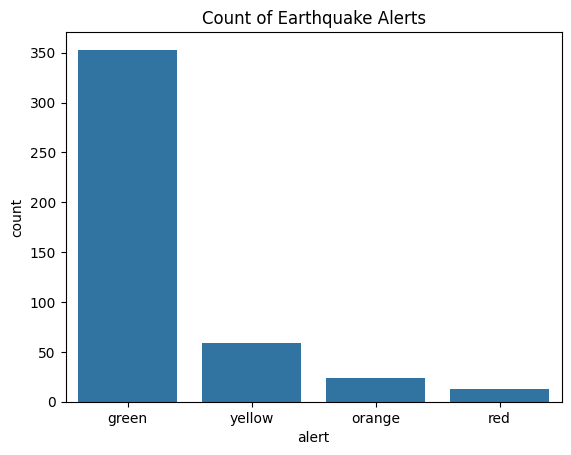

In [ ]:
# Showing distribution of alert levels
sns.countplot(x='alert', data=df)
plt.title("Count of Earthquake Alerts")
plt.savefig("eda1_alert_distribution.png", dpi=300, bbox_inches='tight')
plt.show()


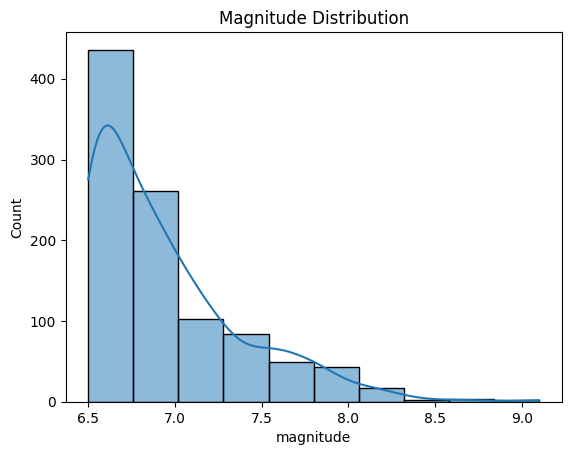

In [ ]:
# Showing histogram of magnitudes
sns.histplot(df['magnitude'], bins=10, kde=True)
plt.title("Magnitude Distribution")
plt.savefig("eda2_magnitude_distribution.png", dpi=300, bbox_inches='tight')
plt.show()


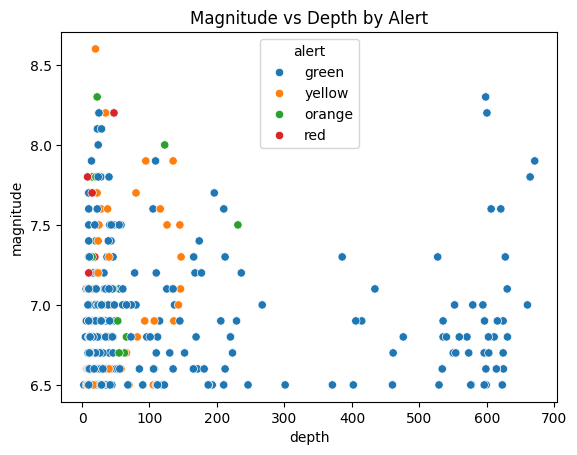

In [ ]:
# Plotting magnitude vs depth by alert level
sns.scatterplot(x='depth', y='magnitude', hue='alert', data=df)
plt.title("Magnitude vs Depth by Alert")
plt.savefig("eda3_magnitude_depth_by_alert.png", dpi=300, bbox_inches='tight')
plt.show()


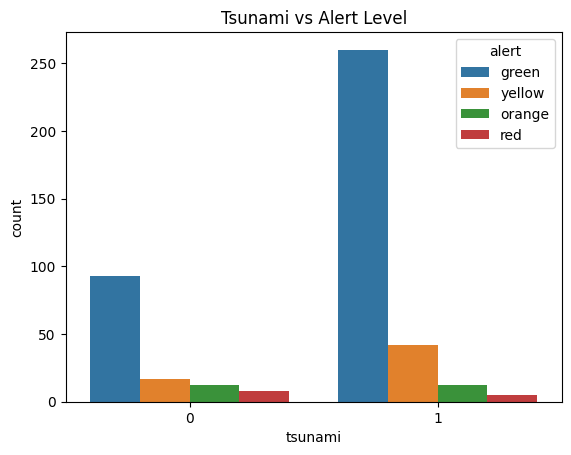

In [ ]:
# Checking if tsunami affects alert level
sns.countplot(x='tsunami', hue='alert', data=df)
plt.title("Tsunami vs Alert Level")
plt.savefig("eda4_tsunami_vs_alert.png", dpi=300, bbox_inches='tight')
plt.show()


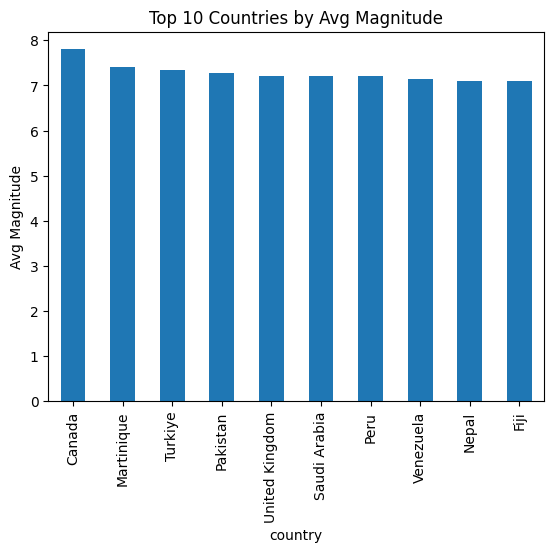

In [ ]:
# Top 10 countries with strongest earthquakes
top_countries = df.groupby('country')['magnitude'].mean().sort_values(ascending=False).head(10)
top_countries.plot(kind='bar', title='Top 10 Countries by Avg Magnitude')
plt.ylabel("Avg Magnitude")
plt.savefig("eda6_top_countries_by_avg_magnitude.png", dpi=300, bbox_inches='tight')
plt.show()


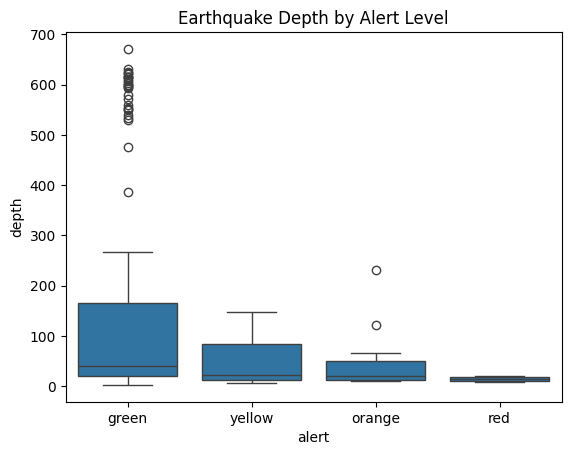

In [ ]:
# Checking distribution of depth by alert level
sns.boxplot(x='alert', y='depth', data=df)
plt.title("Earthquake Depth by Alert Level")
plt.savefig("eda7_depth_by_alert.png", dpi=300, bbox_inches='tight')
plt.show()


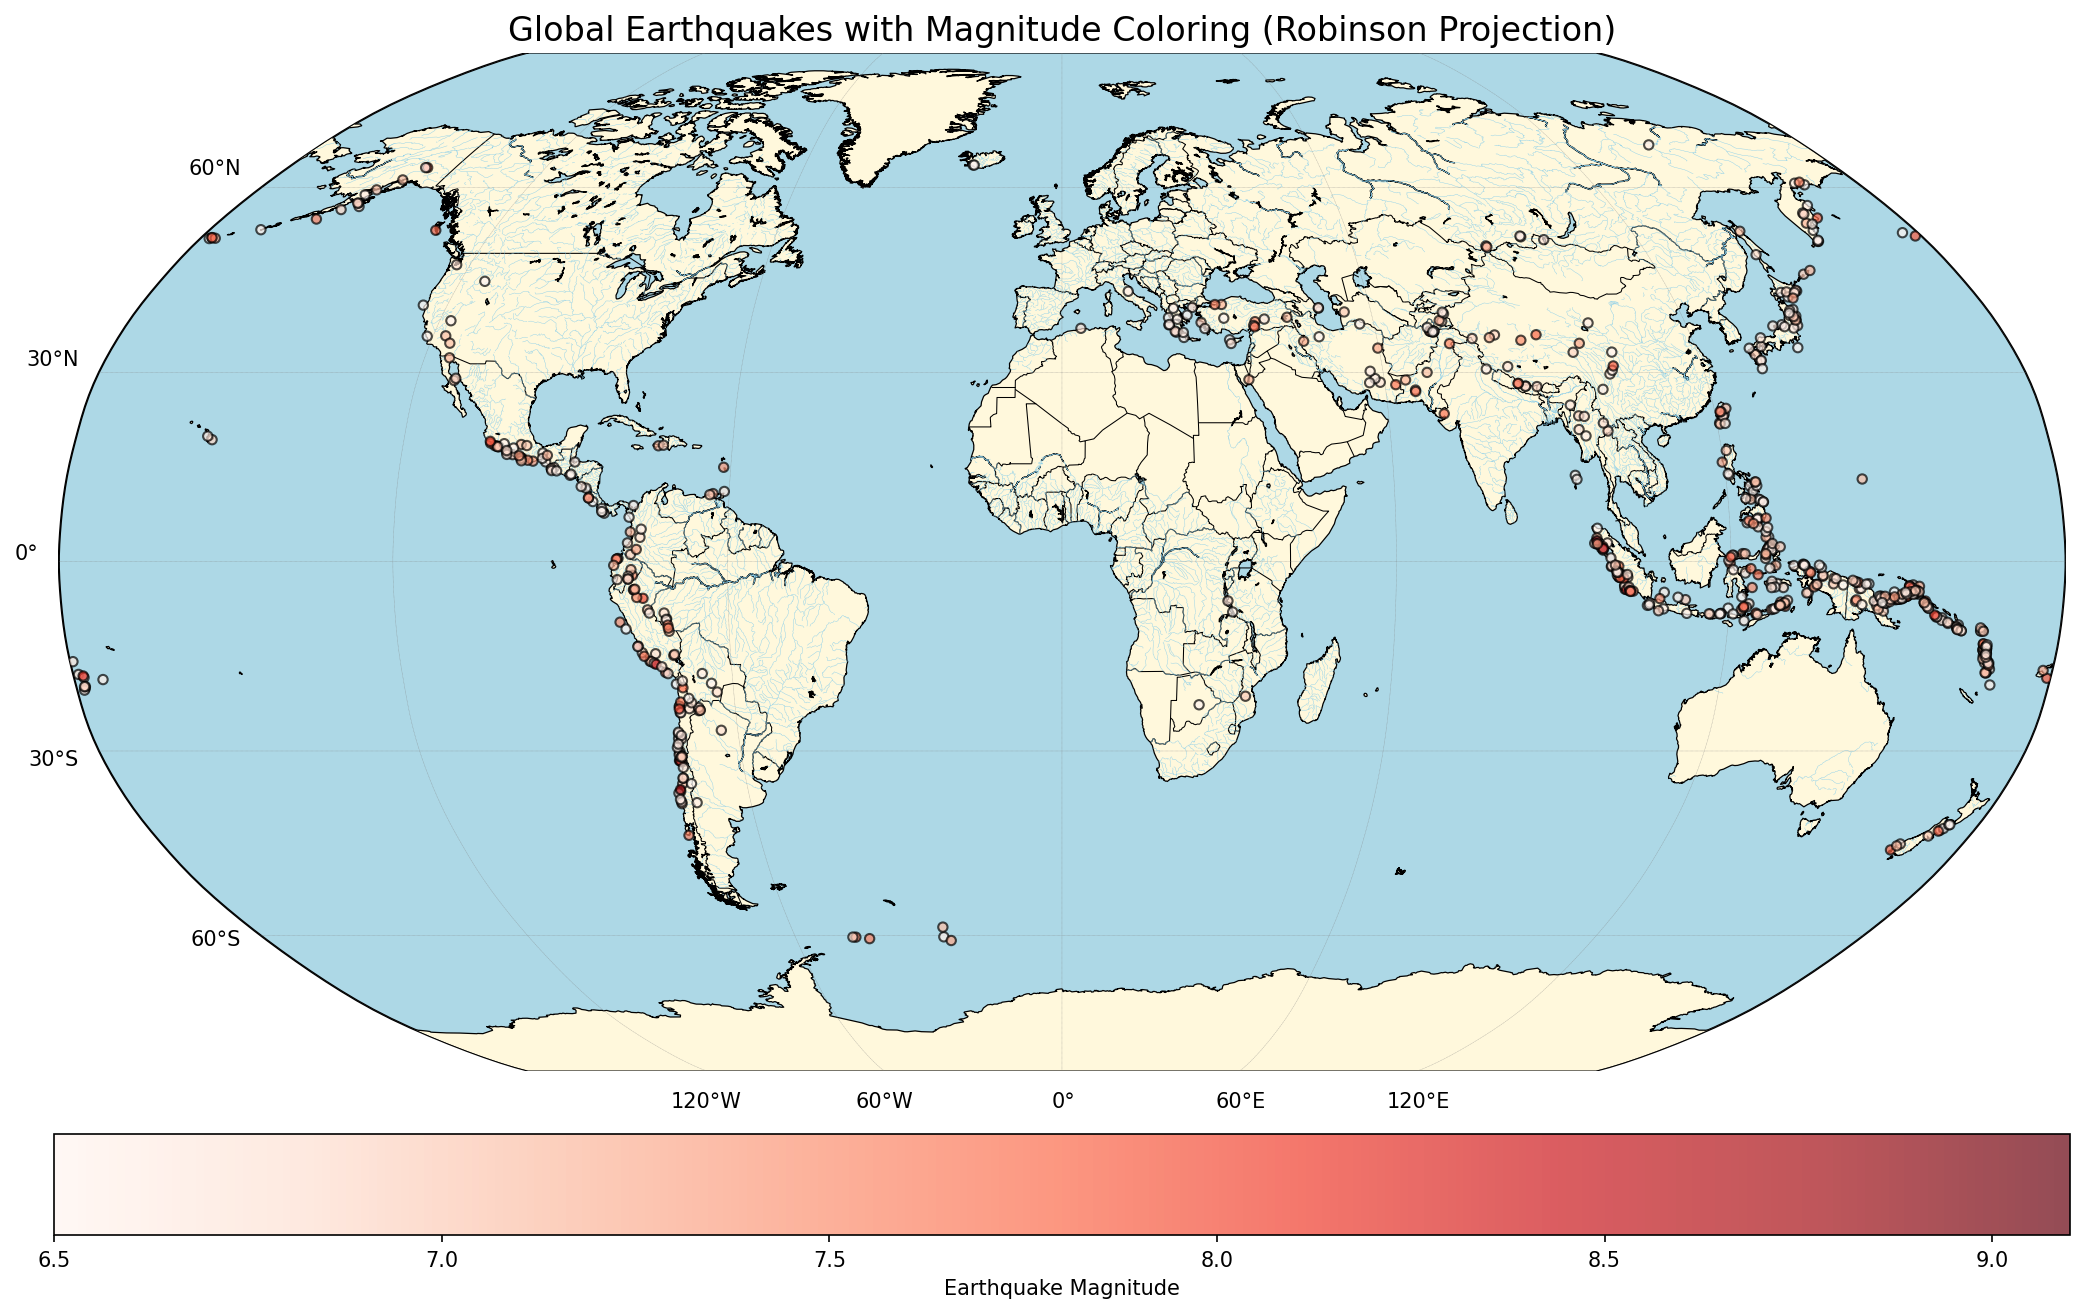

In [ ]:
# Drawing high-quality map with Robinson projection and colored continents
plt.figure(figsize=(14, 9), dpi=150)

m = Basemap(projection='robin', lon_0=0, resolution='l')

# Drawing the basic map
m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='cornsilk', lake_color='lightblue')
m.drawcoastlines(linewidth=0.6)
m.drawcountries(linewidth=0.5)
m.drawrivers(color='skyblue', linewidth=0.2)

# Gridlines
m.drawparallels(np.arange(-90., 91., 30.), labels=[1,0,0,0], color='gray', linewidth=0.2)
m.drawmeridians(np.arange(-180., 181., 60.), labels=[0,0,0,1], color='gray', linewidth=0.2)

# Coloring earthquake points by magnitude
x, y = m(df['longitude'].values, df['latitude'].values)
magnitudes = df['magnitude'].values

# Scatter with magnitude-based color and size
sc = m.scatter(x, y, c=magnitudes, cmap='Reds', s=20, edgecolors='black', alpha=0.7, zorder=5)

# Adding colorbar
cb = plt.colorbar(sc, orientation='horizontal', pad=0.05)
cb.set_label('Earthquake Magnitude')

plt.title("Global Earthquakes with Magnitude Coloring (Robinson Projection)", fontsize=16)
plt.tight_layout()
plt.savefig("eda8_global_earthquakes_map.png", dpi=300, bbox_inches='tight')
plt.show()


Feature Engineering and Scaling

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Dropping or filling NaNs in features
df = df.dropna()
# Define X and y
X = df.drop(columns=['alert', 'date_time']) 
y = df['alert']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Non-Parallel Training

In [ ]:
import time
start = time.time()
model_non = RandomForestClassifier(n_jobs=1, random_state=42)
model_non.fit(X_train_scaled, y_train)
end = time.time()

y_pred_non = model_non.predict(X_test_scaled)
acc_non = accuracy_score(y_test, y_pred_non)
time_non = end - start

print(f"Accuracy (Non-Parallel): {acc_non * 100:.2f}%")
print(f"Time Taken: {time_non:.2f} seconds")


Accuracy (Non-Parallel): 92.50%
Time Taken: 0.27 seconds


Parallel Training

In [ ]:
start = time.time()
model_par = RandomForestClassifier(n_jobs=-1, random_state=42)
model_par.fit(X_train_scaled, y_train)
end = time.time()

y_pred_par = model_par.predict(X_test_scaled)
acc_par = accuracy_score(y_test, y_pred_par)
time_par = end - start

print(f"Accuracy (Parallel): {acc_par * 100:.2f}%")
print(f"Time Taken: {time_par:.2f} seconds")


Accuracy (Parallel): 92.50%
Time Taken: 0.43 seconds


GPU Training

In [ ]:
start = time.time()
model_gpu = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)
model_gpu.fit(X_train_scaled, y_train)
end = time.time()

y_pred_gpu = model_gpu.predict(X_test_scaled)
acc_gpu = accuracy_score(y_test, y_pred_gpu)
time_gpu = end - start

print(f"Accuracy (GPU Mode): {acc_gpu * 100:.2f}%")
print(f"Time Taken: {time_gpu:.2f} seconds")


Accuracy (GPU Mode): 91.50%
Time Taken: 0.92 seconds


In [ ]:
import timeit

def measure_latency(model, X_sample, n_trials=100):
    return timeit.timeit(lambda: model.predict(X_sample), number=n_trials) / n_trials

# Using a sample input from test set
X_sample = X_test_scaled[0].reshape(1, -1)

# Measuring latency in seconds then converting to ms
latency_non = measure_latency(model_non, X_sample)
latency_par = measure_latency(model_par, X_sample)
latency_gpu = measure_latency(model_gpu, X_sample)

# Converting to milliseconds
latency_non_ms = latency_non * 1000
latency_par_ms = latency_par * 1000
latency_gpu_ms = latency_gpu * 1000

print(f"Latency Non-Parallel: {latency_non_ms:.4f} ms")
print(f"Latency Parallel:     {latency_par_ms:.4f} ms")
print(f"Latency GPU Mode:     {latency_gpu_ms:.4f} ms")


Latency Non-Parallel: 23.6388 ms
Latency Parallel:     33.4965 ms
Latency GPU Mode:     74.3982 ms


In [ ]:
acc_non = 92.50
acc_par = 92.50
acc_gpu = 91.50

comparison_df = pd.DataFrame({
    "Mode": ["Non-Parallel", "Parallel", "GPU"],
    "Accuracy (%)": [acc_non, acc_par, acc_gpu],
    "Training Time (s)": [time_non, time_par, time_gpu],
    "Inference Latency (ms)": [latency_non_ms, latency_par_ms, latency_gpu_ms]
})


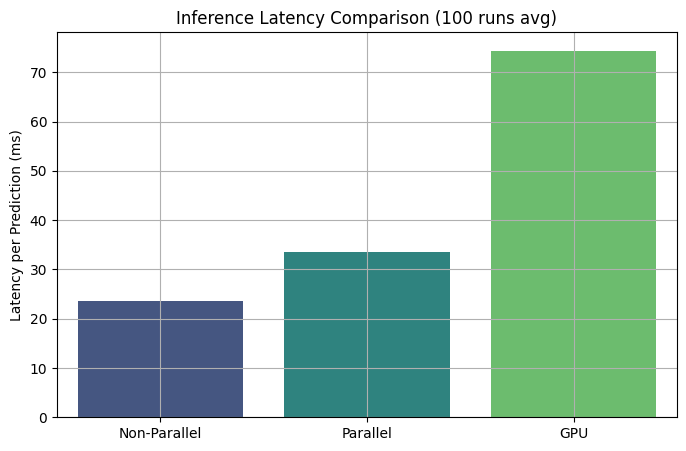

In [ ]:
# Latency Comparison Bar Chart
latencies = [latency_non_ms, latency_par_ms, latency_gpu_ms]
modes = ['Non-Parallel', 'Parallel', 'GPU']

plt.figure(figsize=(8,5))
sns.barplot(x=modes, y=latencies, palette='viridis')
plt.ylabel("Latency per Prediction (ms)")
plt.title("Inference Latency Comparison (100 runs avg)")
plt.grid(True)
plt.savefig("latency_comparison.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
comparison_df = pd.DataFrame({
    "Mode": modes,
    "Accuracy (%)": [acc_non, acc_par, acc_gpu],
    "Training Time (s)": [time_non, time_par, time_gpu],
    "Inference Latency (ms)": [latency_non_ms, latency_par_ms, latency_gpu_ms]
})

print("\n Full Comparison Table:")
print(comparison_df.round(2))



 Full Comparison Table:
           Mode  Accuracy (%)  Training Time (s)  Inference Latency (ms)
0  Non-Parallel          92.5               0.27                   23.64
1      Parallel          92.5               0.43                   33.50
2           GPU          91.5               0.92                   74.40


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Reusable function to save confusion matrix
def save_confusion_matrix(y_true, y_pred, mode_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {mode_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    filename = f"confusion_matrix_{mode_name.lower().replace(' ', '_')}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()
    print(f" Saved: {filename}")

# Save all 3 matrices
save_confusion_matrix(y_test, y_pred_non, "Non-Parallel")
save_confusion_matrix(y_test, y_pred_par, "Parallel")
save_confusion_matrix(y_test, y_pred_gpu, "GPU")


 Saved: confusion_matrix_non-parallel.png
 Saved: confusion_matrix_parallel.png
 Saved: confusion_matrix_gpu.png


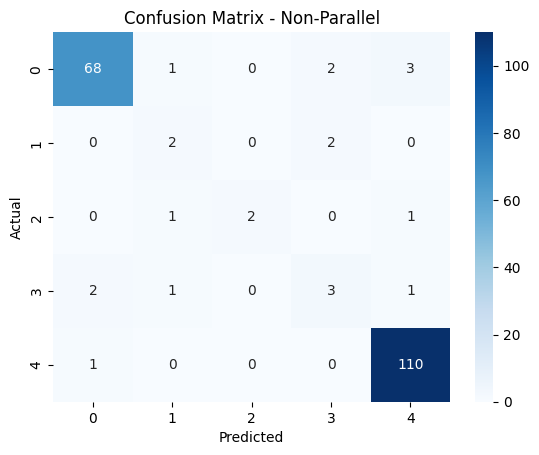

In [ ]:
plot_cm(y_test, y_pred_non, "Non-Parallel")

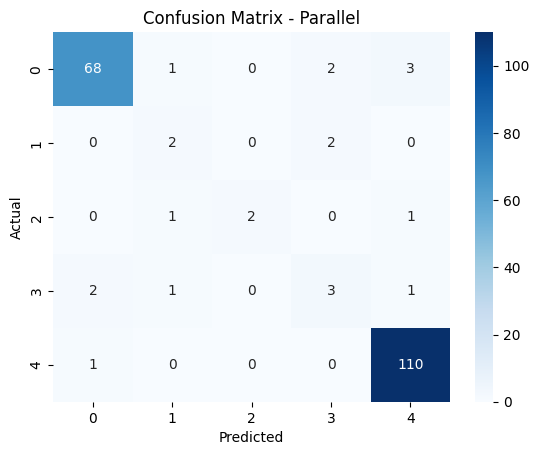

In [ ]:
plot_cm(y_test, y_pred_par, "Parallel")

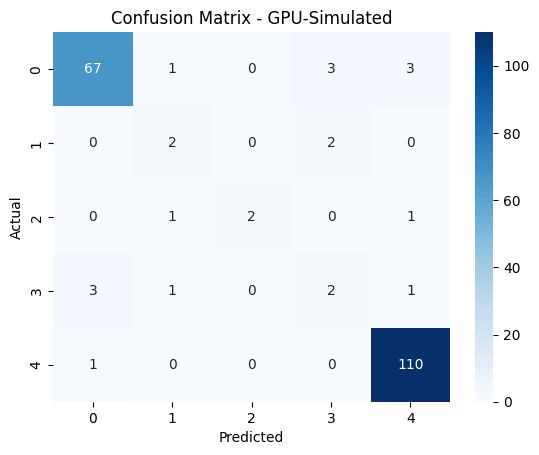

In [ ]:
plot_cm(y_test, y_pred_gpu, "GPU-Simulated")

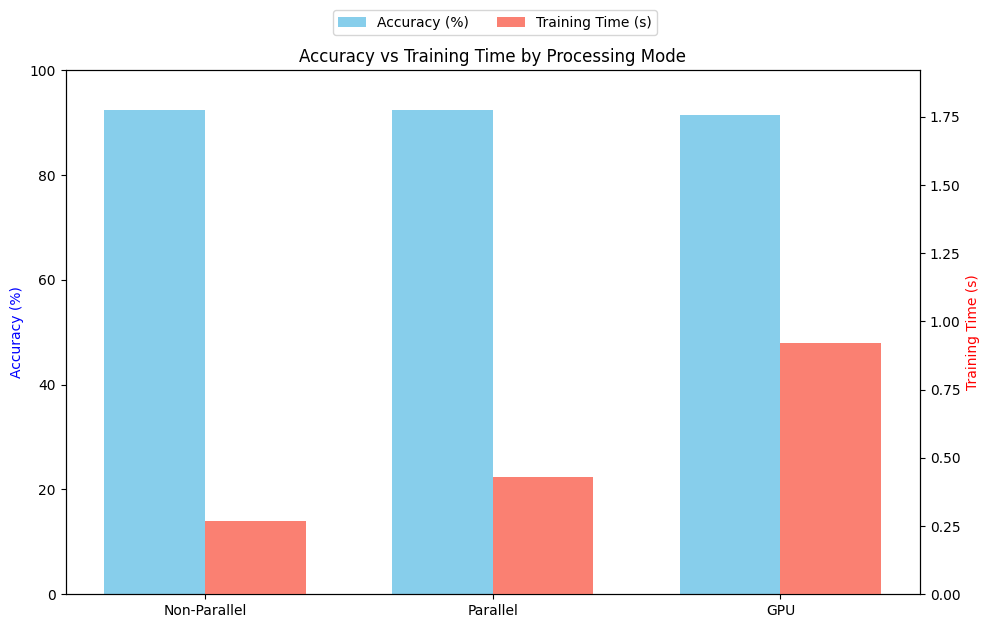

In [ ]:
# Values
modes = ['Non-Parallel', 'Parallel', 'GPU']
accuracies = [92.50, 92.50, 91.50]
training_times = [0.27, 0.43, 0.92]

# Bar positions
x = np.arange(len(modes))
width = 0.35

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bars for accuracy
bar1 = ax1.bar(x - width/2, accuracies, width, label='Accuracy (%)', color='skyblue')

# Bars for time (on second y-axis)
ax2 = ax1.twinx()
bar2 = ax2.bar(x + width/2, training_times, width, label='Training Time (s)', color='salmon')

# Labels and legend
ax1.set_ylabel('Accuracy (%)', color='blue')
ax2.set_ylabel('Training Time (s)', color='red')
ax1.set_xticks(x)
ax1.set_xticklabels(modes)
ax1.set_ylim(0, 100)
ax2.set_ylim(0, max(training_times) + 1)
plt.title('Accuracy vs Training Time by Processing Mode')

# Adding legends manually
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)
plt.tight_layout()
plt.savefig("accuracy_vs_training_time.png", dpi=300, bbox_inches='tight')
plt.show()
